<a href="https://colab.research.google.com/github/pulkitdixit/cnn_ResNet_CIFAR100/blob/master/CIFAR100_Pytorch_GPU_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [0]:
root = 'gdrive/My Drive/Google Colab/'
batch_size = 100
learn_rate = 0.001
scheduler_step_size = 8
scheduler_gamma = 0.5
num_epochs = 50

In [0]:
transform_train = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])

In [5]:
train_dataset = torchvision.datasets.CIFAR100(root = root, train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR100(root = root, train=False, transform=transform_train, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [0]:
def conv3x3(in_channels, out_channels, stride = 1):
  return nn.Conv2d(in_channels, out_channels, stride = stride, kernel_size = 3, padding = 1)

In [0]:
class BasicBlock(nn.Module):
  #expansion = 1
  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)
    self.conv2 = conv3x3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
    self.stride = stride
    
  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
      residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out
  

In [0]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 100):
    super(ResNet, self).__init__()
    
    #Pre-basic block convolution:
    self.in_channels = 32
    self.conv = conv3x3(3, self.in_channels)
    self.bn = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace = True)
    self.drop_out = nn.Dropout(0.1)
    
    #Basic block 1:
    self.layer1 = self.make_layer(block, 32, layers[0])
    
    #Basic block 2:
    self.layer2 = self.make_layer(block, 64, layers[1], 2)
    
    #Basic block 3:
    self.layer3 = self.make_layer(block, 128, layers[2], 2)
    
    #Basic block 3:
    self.layer4 = self.make_layer(block, 256, layers[3], 2)
    
    #Post Block pooling and linearization:
    self.maxpool = nn.AdaptiveMaxPool2d((1,1))
    self.drop_out2 = nn.Dropout(0.1)
    #self.linear = nn.Linear(32*block.expansion, 100)
    self.linear = nn.Linear(256, 100)
    
  def make_layer(self, block, out_channels, layer_len, stride = 1):
    downsample = None
    if (stride != 1) or (self.in_channels != out_channels):
      downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size = 1, stride = stride),
                                nn.BatchNorm2d(out_channels))
    
    layer = []
    layer.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels
    for i in range(1, layer_len):
      layer.append(block(out_channels, out_channels))
    return nn.Sequential(*layer)
  
  def forward(self, x):
    out = self.conv(x)
    #print('First convolution: \t', out.size())
    out = self.bn(out)
    out - self.relu(out)
    out = self.drop_out(out)
    
    out = self.layer1(out)
    out = self.drop_out(out)
    #print('First layer: \t\t', out.size())
    
    out = self.layer2(out)
    out = self.drop_out(out)
    #print('Second layer: \t\t', out.size())
    
    out = self.layer3(out)
    out = self.drop_out(out)
    #print('Second layer: \t\t', out.size())
    
    out = self.layer4(out)
    out = self.drop_out(out)
    #print('Second layer: \t\t', out.size())
    
    out = self.maxpool(out)
    out = self.drop_out2(out)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return(out)
    

In [0]:
layers = [2, 4, 4, 2]
model = ResNet(BasicBlock, layers)

#Enable GPU:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), 
                                lr = learn_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = scheduler_step_size, 
                                            gamma = scheduler_gamma)

In [11]:
train_acc_list = []
test_acc_list = []
for epochs in range(num_epochs):
    scheduler.step()
    correct = 0
    total = 0
    print('Current epoch: \t\t', epochs+1, '/', num_epochs)
    #print('--------------------------------------------------')
    for images, labels in train_loader:
        #images = images.reshape(-1, 16*16)
        images = images
        labels = labels
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc = correct/total
    print('Training accuracy: \t', train_acc)
    #print('--------------------------------------------------')
    train_acc_list.append(train_acc)
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images
            labels = labels
            if use_cuda and torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()
        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total = total + labels.size(0)
            correct = correct + (predicted == labels).sum().item()
    test_acc = correct/total
    print('Test Accuracy: \t\t', test_acc)
    print('**************************************************')
    test_acc_list.append(test_acc)
    model.train()

Current epoch: 		 1 / 50


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training accuracy: 	 0.06752
Test Accuracy: 		 0.1409
**************************************************
Current epoch: 		 2 / 50
Training accuracy: 	 0.16246
Test Accuracy: 		 0.211
**************************************************
Current epoch: 		 3 / 50
Training accuracy: 	 0.24458
Test Accuracy: 		 0.2949
**************************************************
Current epoch: 		 4 / 50
Training accuracy: 	 0.31332
Test Accuracy: 		 0.3488
**************************************************
Current epoch: 		 5 / 50
Training accuracy: 	 0.3692
Test Accuracy: 		 0.3319
**************************************************
Current epoch: 		 6 / 50
Training accuracy: 	 0.41366
Test Accuracy: 		 0.4204
**************************************************
Current epoch: 		 7 / 50
Training accuracy: 	 0.45082
Test Accuracy: 		 0.4381
**************************************************
Current epoch: 		 8 / 50
Training accuracy: 	 0.51832
Test Accuracy: 		 0.4973
**************************************

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


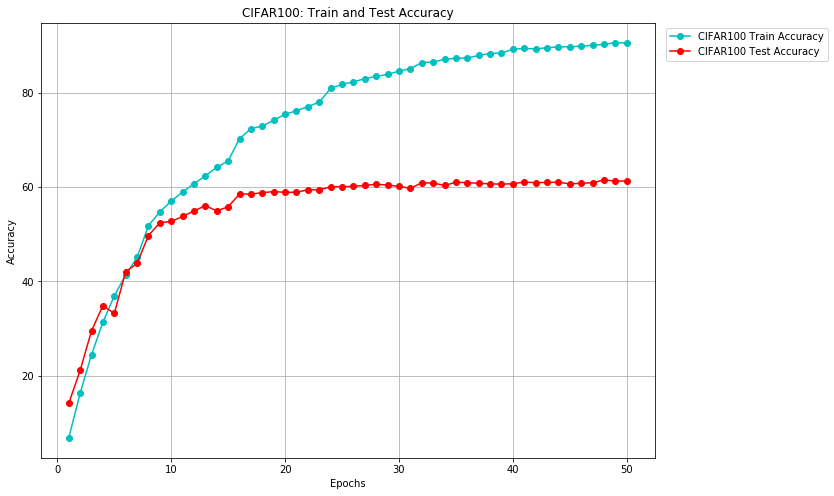

In [38]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(np.arange(1,num_epochs+1), np.array(train_acc_list)*100, label='CIFAR100 Train Accuracy', color='c', marker='o')
ax1.plot(np.arange(1,num_epochs+1), np.array(test_acc_list)*100, label='CIFAR100 Test Accuracy', color='r', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR100: Train and Test Accuracy')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')